<a href="https://colab.research.google.com/github/koshkit/VKR/blob/main/Ensemble_ETU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#==============DATA_PRE-PROCESSING==========================#
import os
import random
import glob
import numpy as np
from numpy.ma.core import size
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#set path to dirs
dir_covid = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/COVID'
dir_opacity = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Lung_Opacity'
dir_normal = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Normal'
dir_pneumonia = '/content/drive/MyDrive/Colab_Notebooks/COVID-19_Radiography_Dataset/Viral_Pneumonia'

#arrays dirs and classes
dir_list=[dir_covid, dir_opacity, dir_normal, dir_pneumonia]
classes=['covid', 'lung_opacity', 'normal', 'pneumonia']

In [2]:
#check dataset for integrity
filepaths=[]
labels=[]
for d,c in zip(dir_list, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  21165    labels:  21165


In [3]:
#create DataFrame
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=DataFrame(np.array(df).reshape(len(labels),2), columns = ['file_paths', 'labels'])

normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: labels, dtype: int64


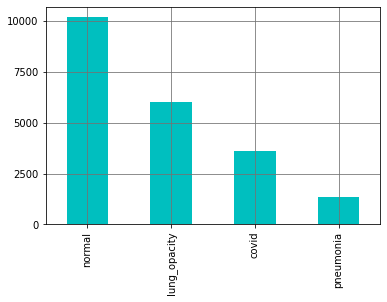

In [4]:
#print and plot df params
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind="bar", color = "c")
plt.rc('font',size=20)
plt.grid(True, c="0.45")
plt.show()

In [5]:
#get class image index
normal_count = df['labels'].value_counts()[0]
lung_opacity_count = df['labels'].value_counts()[1]
covid_count = df['labels'].value_counts()[2]
pneumonia_count = df['labels'].value_counts()[3]
normal_image_max_index = (df.labels.values == 'normal').argmax()
print(normal_image_max_index)
lung_opacity_max_index = (df.labels.values == 'lung_opacity').argmax()
print(lung_opacity_max_index)

9628
3616


In [6]:
#drop rows from df to 'covid' count
for i in range(normal_count - covid_count):
    df = df.drop([normal_image_max_index + i])
    
for n in range(lung_opacity_count - covid_count):
    df = df.drop([lung_opacity_max_index + n])

df['labels'].value_counts()

covid           3616
lung_opacity    3616
normal          3616
pneumonia       1345
Name: labels, dtype: int64

In [7]:
#add Chest X-Ray Images (Pneumonia) Dataset
filepaths=[]
labels=[]
for file in glob.glob('/content/drive/MyDrive/Colab_Notebooks/PNEUMONIA/*.jpeg'):
    filepaths.append(file)
    labels.append('pneumonia')
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3875    labels:  3875


In [8]:
#create extra df
fseries = pd.Series(filepaths, name='file_name', dtype='str')
lseries = pd.Series(labels, name='label', dtype='str')
extra_df = pd.concat([fseries, lseries], axis=1)
extra_df = DataFrame(np.array(extra_df).reshape(len(labels),2), columns = ['file_paths', 'labels'])
extra_df.head()

,file_paths,labels
0,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
1,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
2,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
3,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
4,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia


In [9]:
#merge df with extra_df
df=pd.concat([df,extra_df], axis=0)
df=df.reset_index()
df['labels'].value_counts()
df.head()

,index,file_paths,labels
0,0,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
1,1,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
2,2,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
3,3,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
4,4,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid


In [10]:
pneumonia_count_upd = pneumonia_count + len(labels)
pneumonia_max_index=(df.labels.values == 'pneumonia').argmax()
print(pneumonia_max_index)

10848


In [ ]:
#drop surplus pneumonia
for i in range(pneumonia_count_upd - covid_count):
    df = df.drop([pneumonia_max_index + i])

covid           3616
lung_opacity    3616
normal          3616
pneumonia       3616
Name: labels, dtype: int64


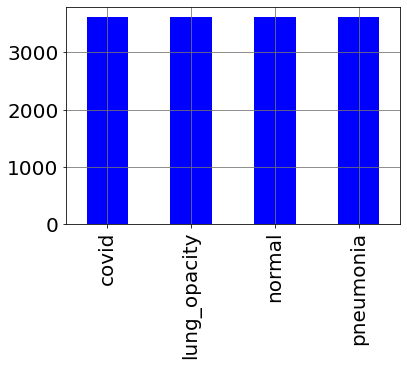

In [ ]:
#plot current dataset state
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind="bar", color = "b")
plt.rc('font',size=20)
plt.grid(True, c="0.45")
plt.show()
#------------------DATA_PRE-PROCESSING---------------------------#

In [ ]:
#==================DIVIDE_DATA_SET===============================#
df=df.sample(frac=1)
df.head()

,index,file_paths,labels
8131,17103,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,normal
16026,3833,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
8046,17018,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,normal
1826,1826,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
6796,9192,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity


In [ ]:
target_size=(299,299)#image size
batch_size=64

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, validation_split=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state = 357)
train_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='training')
valid_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='validation')
test_set = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical')
test_x, test_y = next(test_set)

Found 10414 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Found 2893 validated image filenames belonging to 4 classes.


In [ ]:
train_df.head()

,index,file_paths,labels
2210,2210,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
3956,6352,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity
2168,2168,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
13363,1170,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia
13040,847,/content/drive/MyDrive/Colab_Notebooks/PNEUMON...,pneumonia


In [ ]:
test_df.head()

,index,file_paths,labels
4309,6705,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity
6495,8891,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,lung_opacity
1758,1758,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
1710,1710,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid
2791,2791,/content/drive/MyDrive/Colab_Notebooks/COVID-1...,covid


In [ ]:
print(test_df['labels'].value_counts())

lung_opacity    764
covid           739
pneumonia       704
normal          686
Name: labels, dtype: int64


In [ ]:
print(train_df['labels'].value_counts())
#------------------DIVIDE_DATA_SET------------------------------#

normal          2930
pneumonia       2912
covid           2877
lung_opacity    2852
Name: labels, dtype: int64
